
![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - OBD matrix
In this tutorial you generate an overlapping B-mode deprojection matrix, and apply it to a noisemodel using a masked sky.
At the end of this tutorial, you will plot the power spectrum of a simulation, with the $B$-modes deprojected using the OBD matrix.

This tutorial uses two configuration files to generate and apply the OBD matrix to simulations. The [first](https://github.com/NextGenCMB/delensalot/blob/simgenjob/notebooks/examples/conf_mwe_buildOBD.py) is for generating the OBD matrix, and you can freely change the parameters to your liking. 

The 
 * `DLENSALOT_Analysis` is mainly needed for pointing delensalot to the mask you will generate in this notebook,
 * `DLENSALOT_Noisemodel` configures the noise model. You should choose the setting applicable to the simulations and/or data you'd like to deproject,
 * `DLENSALOT_OBD` defines where the Matrix temp and final files are stored and other simulation and/or data specific settings

In [1]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj
if "SCRATCH" not in os.environ:
    os.environ["SCRATCH"] = "/mnt/c/Users/sebas/OneDrive/SCRATCH"

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import delensalot
from delensalot.run import run
from delensalot.lerepi.visalot import plot_helper as ph

cond4mpi does not exists. No MPI loaded
mpi.py: Plancklens.mpi disabled as per environ variable 



# Create mask
The following cell is a template for generating a simple mask and stores it in the `delensalot.TEMP` folder. (Make sure that this matches the configuration file setting)

fsky: 0.083


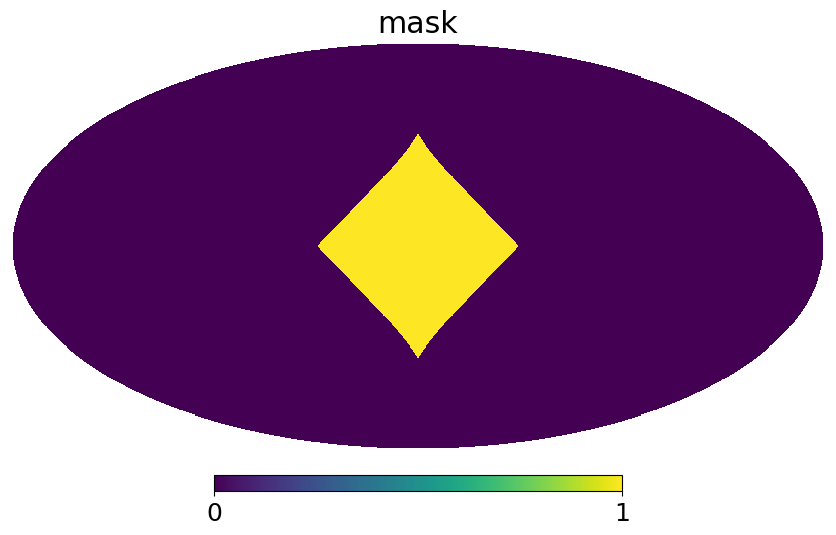

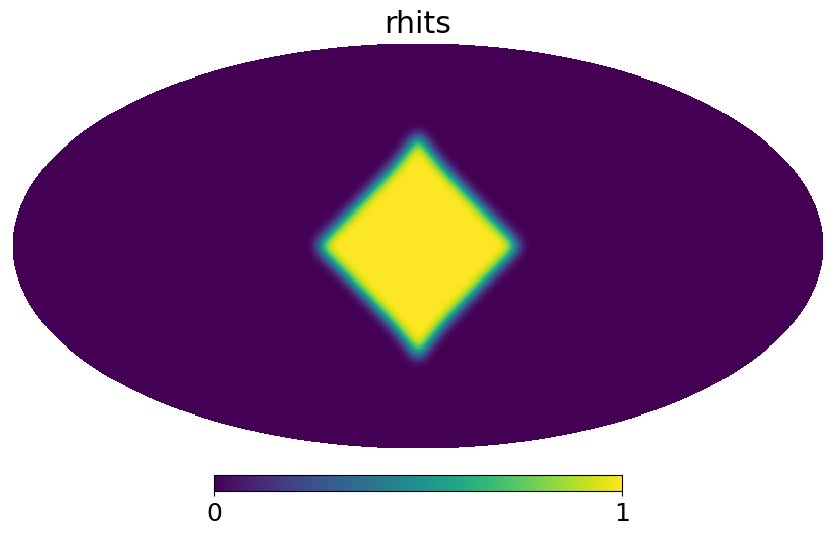

In [2]:
m = np.zeros(hp.nside2npix(1))
m[[4]] = 1
nside = 512
rhits = np.abs(hp.smoothing(hp.ud_grade(m, nside_out=nside),0.1))
mask = hp.ud_grade(m, nside_out=nside)
hp.mollview(mask, title='mask')
hp.mollview(rhits, title='rhits')
fsky = np.mean(m)
print('fsky: {:.3f}'.format(fsky))

mask_fn = opj(os.environ['SCRATCH'], 'OBDmatrix', 'my_first_dlensalot_analysis', 'nside512', 'lmax1024', 'lcut100', 'mask.fits')
rhits_fn = opj(os.environ['SCRATCH'], 'OBDmatrix', 'my_first_dlensalot_analysis', 'nside512', 'lmax1024', 'lcut100', 'rhits.fits')

if not os.path.isdir(os.path.dirname(mask_fn)):
    os.makedirs(os.path.dirname(mask_fn))
    
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, mask)
    hp.write_map(rhits_fn, rhits)
    print('mask and rhtis stored at {}'.format(os.path.dirname(mask_fn)))

# Create the OBD matrix
If the sky wasn't masked, deprojecting the B-modes would simply be truncating the transfer function at the respective multipole range.
But due to masking the noise model is no longer isotropic.

To deproject the modes, we will transform the noise model $N$ as follows,

 * $ N^{-1} \rightarrow N^{-1} - P^{\dagger}\left[1/\sigma^2+PN^{-1}P^{\dagger}\right]^{-1}PN^{-1}$

where $\sigma^2$ is a sufficiently high noise value chosen for the modes we want to deproject, and $P$ is the Stokes polarization pattern from a CMB sky. 

The next cell may take a while (~30minutes), go grab a coffee.

In [2]:
fn = opj(os.getcwd(), 'conf_mwe_buildOBD.py')
ana_mwe = run(config=fn, job_id='build_OBD', verbose=True)
ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 14:05:04


# Apply to simulation data
The [second](https://github.com/NextGenCMB/delensalot/blob/sv3.1/delensalot/ana/config/examples/mwe/conf_mwe_applyOBD.py)
configuration file generates a single simulated CMB inclusive of noise and performs QE lensing reconstruction (`job_id="QE_lensrec"`). QE lensing reconstruction includes the filtering of the CMB maps; exactly what we want.

In addition, we prepared a [third](https://github.com/NextGenCMB/delensalot/blob/sv3.1/delensalot/ana/config/examples/mwe/conf_mwe_applynoOBD.py) configuration file which deproject the $B$-modes isotropically. They would be equivalent in the full-sky case. However, in this tutorial here, they lead to different results, demonstrating the need of correctly (OBD) deprojecting the $B$-modes

In [3]:
fn = opj(os.getcwd(), 'conf_mwe_applyOBD.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True)
ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 13:52:40


In [5]:
fn = opj(os.getcwd(), 'conf_mwe_applynoOBD.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True)
ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 14:00:33


# Check your result
If the OBD has correctly been applied, the filtered CMB $B$-map's low $\ell$-modes are supressed.
The filtered modes are accessed via the `ivfs.ivfs` object, the input simulation data via `_sims`.

In [2]:
fn = opj(os.getcwd(), 'conf_mwe_applynoOBD.py')
ana_mwe_noOBD = run(config=fn, job_id='QE_lensrec', verbose=True)
ana_mwe_noOBD.run()
ana_mwe_noOBD = ana_mwe_noOBD.job

fn = opj(os.getcwd(), 'conf_mwe_applyOBD.py')
ana_mwe_OBD = run(config=fn, job_id='QE_lensrec', verbose=True)
ana_mwe_OBD.run()
ana_mwe_OBD = ana_mwe_OBD.job

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 14:43:00


To compare them with one another, we apply a simple inverse variance filter to the simulation data, and show the inverse variance filtered $B$ power spectra for the OBD and trunacted case.

The mismatch at small scales between the (ivfs) and the properly filtered $B$-mode maps is due to the pseudo power spectrum calculation on this small patch.

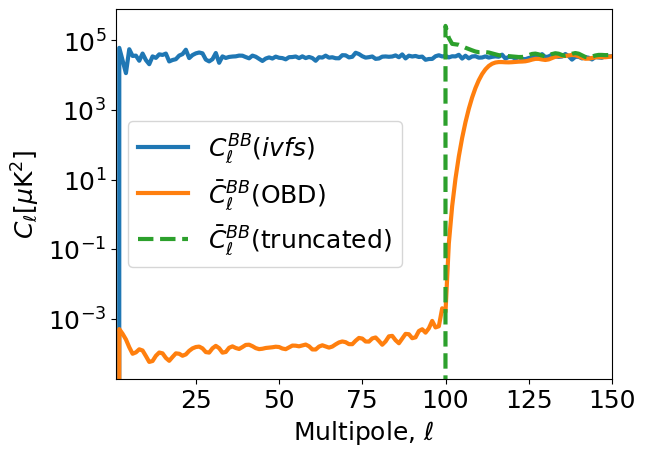

In [14]:
b_sim_noOBD = ana_mwe_noOBD._sims.get_sim_blm(0)
b_sim_ivfs_noOBD = ana_mwe_noOBD.ivfs.ivfs.get_sim_blm(0)
b_sim_ivfs_OBD = ana_mwe_OBD.ivfs.ivfs.get_sim_blm(0)
N = (ana_mwe_noOBD.nlev_p/180/60*np.pi)**2


plt.plot(hp.alm2cl(b_sim_noOBD)*ana_mwe_OBD.fsky/(ana_mwe_noOBD.cls_len['bb'][:1025]+N)**2, label=r'$C_\ell^{BB} (ivfs)$', lw=3)
plt.plot(hp.alm2cl(b_sim_ivfs_OBD), label=r'$\bar{C}_\ell^{BB}$(OBD)', lw=3)
plt.plot(hp.alm2cl(b_sim_ivfs_noOBD), label=r'$\bar{C}_\ell^{BB}$(truncated)', lw=3, ls='--')
plt.yscale('log')
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')
plt.legend()

plt.xlim(1,150)
# plt.ylim(1e4,2e5)
plt.show()

If everything went right, you should see a
 * rather straight blue line which is merely the inverse variance filtered $B$ power scaled by `fsky`,
 * green line which cuts at $\ell=100$
 * orange line which cuts at $\ell=100$, and compared to the green line, does not show the Fourier spike right at the edge $\ell=100$, and its power is suppressed by about $1e-8$, just as we would expect from the configuration.
This concludes the tutorial about applying the OBD matrix to the noise model.
Please check out the other tutorials, our documentation, or GitHub for more.